### Step 1: Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


### Step 2: Install prerequisites

In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

# To write to word document install python-docx
!pip install python-docx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 65.4 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudio2 amd64 19.6.0-1build1 [65.4 kB]
Fetched 65.4 kB in 1s (82.9 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 128276

### Step 3: Import libraries

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


### Step 4: Choose the model spec

In [ ]:
spec = model_spec.get('efficientdet_lite0')
spec.config.model_dir = "drive/MyDrive/LabelledData-6-classes/junk"

#OPTION to turn on verbosity
spec.config.verbose = 1
spec.config.learning_rate=0.001 #default is 0.08
spec.config.lr_warmup_init=0.0001
spec.config.lr_warup_epoch=10
print(spec.config)

act_type: relu6
alpha: 0.25
anchor_scale: 3.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-lite0
batch_norm_trainable: true
batch_size: 64
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
debug: false
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: sum
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: !!python/tuple
- 320
- 320
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.001
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.0001
lr_warup_

### Step 5: Configure Dataset

In [ ]:
# setup the directory names

image_dir="drive/MyDrive/LabelledData-6-classes"
label_map_file ="drive/MyDrive/LabelledData-6-classes/Stroke_label_map.pbtxt"
print("image_dir\n")
print(image_dir)

test_dir="drive/MyDrive/LabelledData-6-classes/test"
train_dir="drive/MyDrive/LabelledData-6-classes/train"
valid_dir="drive/MyDrive/LabelledData-6-classes/valid"



trainAnnotations_dir="drive/MyDrive/LabelledData-6-classes/train_annotation"
validationAnnotations_dir="drive/MyDrive/LabelledData-6-classes/valid_annotation"
testAnnotations_dir="drive/MyDrive/LabelledData-6-classes/test_annotation"

print("\n\nannotations\n")
print(trainAnnotations_dir)
print(validationAnnotations_dir)
print(testAnnotations_dir)
print("\n\nlabel_map_file")
!cat $label_map_file
%ls -1 {train_dir} | wc -l
%ls -1 {valid_dir} | wc -l
%ls -1 {test_dir} | wc -l

image_dir

drive/MyDrive/LabelledData-6-classes


annotations

drive/MyDrive/LabelledData-6-classes/train_annotation
drive/MyDrive/LabelledData-6-classes/valid_annotation
drive/MyDrive/LabelledData-6-classes/test_annotation


label_map_file
item {
    name: "strokeEyeMid",
    id: 1,
    display_name: "strokeEyeMid"
}
item {
    name: "strokeEyeSevere",
    id: 2,
    display_name: "strokeEyeSevere"
}
item {
    name: "strokeEyeWeakNormal",
    id: 3,
    display_name: "strokeEyeWeakNormal"
}
item {
    name: "strokeMouthMid",
    id: 4,
    display_name: "strokeMouthMid"
}
item {
    name: "strokeMouthSevere",
    id: 5,
    display_name: "strokeMouthSevere"
}
item {
    name: "strokeMouthWeakNormal",
    id: 6,
    display_name: "strokeMouthWeakNormal"
}
748
53
51


In [ ]:
# Validate if images are in JPEG

import glob
from PIL import Image
filepattern = image_dir + "/train/*"
print(filepattern)
print(filepattern)
files = glob.glob(filepattern)
len(files)
for file in files:
  if ".jpg" in file:
    image = Image.open(file)
    if image.format not in ["JPG", "JPEG"]:
      print (file)
      image.convert("RGB").save(file, "JPEG")
  else:
    print("file not jpg: ", file )

print("****************TRY AGAIN *************")
for file in files:
  if ".jpg" in file:
    image = Image.open(file)
    if image.format not in ["JPG", "JPEG"]:
      print (file)
  else:
    print("file not jpg: ", file )

drive/MyDrive/LabelledData-6-classes/train/*
drive/MyDrive/LabelledData-6-classes/train/*
****************TRY AGAIN *************


In [ ]:
#load the data from the Pascal VOC

train_data = object_detector.DataLoader.from_pascal_voc(train_dir, trainAnnotations_dir, label_map={1: "strokeEyeMid", 2: "strokeEyeSevere", 3: "strokeEyeWeakNormal", 4: "strokeMouthMid", 5: "strokeMouthSevere", 6: "strokeMouthWeakNormal"})
validation_data = object_detector.DataLoader.from_pascal_voc(valid_dir, validationAnnotations_dir, label_map={1: "strokeEyeMid", 2: "strokeEyeSevere", 3: "strokeEyeWeakNormal", 4: "strokeMouthMid", 5: "strokeMouthSevere", 6: "strokeMouthWeakNormal"})
test_data = object_detector.DataLoader.from_pascal_voc(test_dir, testAnnotations_dir, label_map={1: "strokeEyeMid", 2: "strokeEyeSevere", 3: "strokeEyeWeakNormal", 4: "strokeMouthMid", 5: "strokeMouthSevere", 6: "strokeMouthWeakNormal"})

### Step 6: Train from scratch

In [ ]:
#@title
# train the model from initial stage
epochs = 1000
batch_size = 20
model = object_detector.create(train_data, model_spec=spec, batch_size=batch_size, train_whole_model=True, validation_data=validation_data, epochs=epochs)

Epoch 1/1000
37/37 [==============================] - ETA: 0s - det_loss: 1.8349 - cls_loss: 1.1866 - box_loss: 0.0130 - reg_l2_loss: 0.0637 - loss: 1.8986 - learning_rate: 2.0338e-04 - gradient_norm: 1.3192
Epoch 1: saving model to drive/MyDrive/LabelledData-6-classes/junk/ckpt-1
37/37 [==============================] - 64s 587ms/step - det_loss: 1.8343 - cls_loss: 1.1865 - box_loss: 0.0130 - reg_l2_loss: 0.0637 - loss: 1.8980 - learning_rate: 2.0610e-04 - gradient_norm: 1.3178 - val_det_loss: 1.7715 - val_cls_loss: 1.1732 - val_box_loss: 0.0120 - val_reg_l2_loss: 0.0637 - val_loss: 1.8352
Epoch 2/1000
37/37 [==============================] - ETA: 0s - det_loss: 1.8029 - cls_loss: 1.1838 - box_loss: 0.0124 - reg_l2_loss: 0.0637 - loss: 1.8666 - learning_rate: 3.1250e-04 - gradient_norm: 1.2338
Epoch 2: saving model to drive/MyDrive/LabelledData-6-classes/junk/ckpt-2
37/37 [==============================] - 19s 513ms/step - det_loss: 1.8013 - cls_loss: 1.1836 - box_loss: 0.0124 - reg_l

### Step 7: Train from checkpoint

In [ ]:
# Step 7.1: train from checkpoint

#Import the same libs that TFLiteModelMaker interally uses
from tensorflow_examples.lite.model_maker.third_party.efficientdet.keras import train
from tensorflow_examples.lite.model_maker.third_party.efficientdet.keras import train_lib

#checkpoints saved in model_dir
checkpoint_dir = spec.config.model_dir  
print(checkpoint_dir)

#set number of epoch and batch_size to train and then train
epochs = 1141
batch_size = 20

#Create the object detector and NOTE do_train is false as we want to only load the architecture so below
# can load the model from weights rather than train from scratch
detector = object_detector.create(train_data, 
                                model_spec=spec, 
                                batch_size=batch_size, 
                                train_whole_model=True, 
                                validation_data=validation_data,
                                epochs = epochs,
                                do_train = False
                                )   






#NOTE: From here on we use internal/"private" functions of the API,
# you can tell because the methods's names begin with an underscore
 

#Convert the datasets for training from a checkpoint specification which will use steps per epcoh 
train_ds, steps_per_epoch, _ = detector._get_dataset_and_steps(train_data, batch_size, is_training = True)
validation_ds, validation_steps, val_json_file = detector._get_dataset_and_steps(validation_data, batch_size, is_training = False)


#create the model from the above specified detector
model = detector.create_model()

#Copy what the API interally does as setup to use steps_per_epoch
config = spec.config
config.update(
    dict(
        steps_per_epoch=steps_per_epoch,
        eval_samples=batch_size * validation_steps,
        val_json_file=val_json_file,
        batch_size=batch_size
    )
)

train.setup_model(model, config) #This is the model.compile call basically so then can call model.fit below to train
model.summary()



#Find the last checkpoint in the checkpoint directory and load the weights
try:
  #Option A:
  #load the weights from the last successfully completed epoch
  latest = tf.train.latest_checkpoint(checkpoint_dir) 

  #Option B:
  #load the weights from a specific checkpoint
  #latest = specific_checkpoint_dir

  #determine the number of the last completed epoch
  completed_epochs = int(latest.split("/")[-1].split("-")[1]) #the epoch the training was at when the training was last interrupted
  model.load_weights(latest)

  print("Checkpoint found {}".format(latest))
  print("# completed epochs previously trained " + str(completed_epochs))
except Exception as e:
  print("Checkpoint not found: ", e)


drive/MyDrive/Stroke/junk
Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  multiple                  3234464   
                                                                 
 class_net/class-predict (Se  multiple                 5256      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 2916      
 bleConv2D)                                                      
                                                                 
Total params: 3,242,636
Trainable params: 3,195,500
Non-trainable params: 47,136
_________________________________________________________________
Checkpoint found drive/MyDrive/Stroke/junk/ckpt-1141
# completed epochs previously trained 1141


In [ ]:
#STEP 7.2:  CONTINUE TRAINING FROM THE CHECKPOINT LOADED MODEL - from the completed_epochs out to # epochs 
print(train_data)

#Add callbacks that get executed at the end of every N 
#epochs: in this case I want to log the training results to tensorboard.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=spec.config.model_dir, histogram_freq=1)
callbacks = train_lib.get_callbacks(config.as_dict(), validation_ds)
callbacks.append(tensorboard_callback)

callbacks.append(tensorboard_callback)
print(" callbacks = " + str(callbacks) +"\n\n")
print(" Tensorboard will log to " + str(spec.config.model_dir))


"""
Train the model 
"""
model.fit(
    # train_data,
    train_ds,   #as training with steps using fit function present data as train_ds rather than train_data as used in create() during train from scratch
    epochs=epochs,
    initial_epoch=completed_epochs, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_ds,
    validation_steps=validation_steps,
    callbacks=train_lib.get_callbacks(config.as_dict(), validation_ds) 
)

### Correction for STEP 7.2

In [ ]:
#STEP 7.2:  CONTINUE TRAINING FROM THE CHECKPOINT LOADED MODEL - from the completed_epochs out to # epochs 
# see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
print(train_data)

#Add callbacks that get executed at the end of every N 
#epochs: in this case I want to log the training results to tensorboard.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=spec.config.model_dir, histogram_freq=1)
callbacks2 = train_lib.get_callbacks(config.as_dict(), validation_ds)
callbacks2.append(tensorboard_callback)

print(" callbacks = " + str(callbacks2) +"\n\n")
print(" Tensorboard will log to " + str(spec.config.model_dir))


"""
Train the model 
"""
model.fit(
    # train_data,
    train_ds,   #as training with steps using fit function present data as train_ds rather than train_data as used in create() during train from scratch
    epochs=epochs,
    initial_epoch=completed_epochs, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_ds,
    validation_steps=validation_steps,
    callbacks=[callbacks2] 
)

 callbacks = [<keras.callbacks.ModelCheckpoint object at 0x7f0102011f40>, <keras.callbacks.TensorBoard object at 0x7f0102011eb0>, <tensorflow_examples.lite.model_maker.third_party.efficientdet.keras.train_lib.COCOCallback object at 0x7f0102011d90>, <keras.callbacks.TensorBoard object at 0x7f0102011fa0>]


 Tensorboard will log to drive/MyDrive/Stroke/junk


### Step 8: Evaluate

Evaluate Model

In [ ]:


# test_ds, test_steps, test_json_file = detector._get_dataset_and_steps(validation_data, batch_size, is_training = False)
# detector.model = model
# detector.summary()
model.evaluate(test_data)

1/1 [==============================] - 24s 24s/step



{'AP': 0.32369944,
 'AP50': 0.5346424,
 'AP75': 0.34657598,
 'APs': 0.61213696,
 'APm': 0.30351278,
 'APl': 0.62289923,
 'ARmax1': 0.5705856,
 'ARmax10': 0.61747444,
 'ARmax100': 0.6224136,
 'ARs': 0.6575,
 'ARm': 0.6244608,
 'ARl': 0.71666664,
 'AP_/strokeEyeMid': 0.26157027,
 'AP_/strokeEyeSevere': 0.30192518,
 'AP_/strokeEyeWeakNormal': 0.3977797,
 'AP_/strokeMouthMid': 0.16985261,
 'AP_/strokeMouthSevere': 0.42313513,
 'AP_/strokeMouthWeakNormal': 0.38793376}

Evaluate tflite model

In [ ]:
detector.evaluate_tflite('drive/MyDrive/Copy of 20230228-200719-model.tflite',test_data)

52/52 [==============================] - 5s 89ms/step



{'AP': 0.21107548,
 'AP50': 0.3196908,
 'AP75': 0.22304732,
 'APs': 0.22173268,
 'APm': 0.2103039,
 'APl': 0.43465346,
 'ARmax1': 0.32087794,
 'ARmax10': 0.32087794,
 'ARmax100': 0.32087794,
 'ARs': 0.28125,
 'ARm': 0.31329367,
 'ARl': 0.43333334,
 'AP_/normalEye': 0.20618811,
 'AP_/normalMouth': 0.25630063,
 'AP_/strokeEyeMid': 0.104097486,
 'AP_/strokeEyeSevere': 0.29315183,
 'AP_/strokeEyeWeak': 0.14697047,
 'AP_/strokeMouthMid': 0.13531353,
 'AP_/strokeMouthSevere': 0.3624234,
 'AP_/strokeMouthWeak': 0.18415841}

In [ ]:
# SOUJANYA  FIX FOR ABOVE CELL, you should load from directory test_data not validation_data
test_ds, test_steps, test_json_file = detector._get_dataset_and_steps(test_data, batch_size, is_training = False)

model.evaluate(test_ds)

2/2 [==============================] - 9s 2s/step - det_loss: 0.6266 - cls_loss: 0.4928 - box_loss: 0.0027 - reg_l2_loss: 0.0639 - loss: 0.6905


[0.0029847866389900446,
 0.5032555460929871,
 0.6524949073791504,
 0.7163993120193481,
 0.06390441954135895]

### Step 9: Save/Export Model

In [ ]:
"""
Save/export the trained model
Tip: for integer quantization you simply have to NOT SPECIFY 
the quantization_config parameter of the detector.export method
"""
import time
quant_config = QuantizationConfig.for_float16() #or whatever quantization you want
detector.model = model #inject our trained model into the object detector
detector.export(export_dir = image_dir, tflite_filename=time.strftime("%Y%m%d-%H%M%S-")+'model.tflite', quantization_config = quant_config)

## **TENSORBOARD curves**


**Impact of the number of classes N on the dumb-logloss:**

***>>>> Minimum Loss Value:***  note  Loss = 0 means that with probability =1 you predict the classes (perfect)

***>>>> Maximum Loss Value:***  (theoretically there is none but, if your system was dumb and just randomly selected a class what would you get)

N = number of classes

Random guessing (no learning) = 


> In the balanced case (every class has the same prevalence), when you predict p =  prevalence = 1 / N for every observation, the equation becomes simply :



> Logloss = -log(1 / N)



> log being Ln, neperian logarithm for those who use that convention.






* In the binary case, N = 2 : Logloss = - log(1/2) = 0.693
*  What about when N > 2



So the dumb-Loglosses are the following :
Note regarding loss the dumb (radom change) loss values as number of classes change:

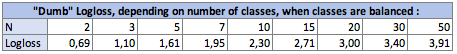

In [ ]:
# !lsof -i:6006
# !kill 10680

!ls 'drive/MyDrive/LabelledData-8-classes'

junk


In [ ]:
%load_ext tensorboard
import datetime, os
logs = "drive/MyDrive/LabelledData-6-classes/junk"

%cd $logs
%tensorboard --logdir .

### Evaluate from checkpoint

In [ ]:
# Step 1: Load the Model from the Checkpoint
#Import the same libs that TFLiteModelMaker interally uses
from tensorflow_examples.lite.model_maker.third_party.efficientdet.keras import train
from tensorflow_examples.lite.model_maker.third_party.efficientdet.keras import train_lib

#checkpoints saved in model_dir
# checkpoint_dir = spec.config.model_dir  
# checkpoint_dir = "drive/MyDrive/Stroke/ckpt-220"
# print(checkpoint_dir)

#set number of epoch and batch_size to train and then train
epochs = 1000
batch_size = 20

#Create the object detector and NOTE do_train is false as we want to only load the architecture so below
# can load the model from weights rather than train from scratch
detector = object_detector.create(train_data, 
                                model_spec=spec, 
                                batch_size=batch_size, 
                                train_whole_model=True, 
                                validation_data=validation_data,
                                epochs = epochs,
                                do_train = False
                                )   






#NOTE: From here on we use internal/"private" functions of the API,
# you can tell because the methods's names begin with an underscore
 

#Convert the datasets for training from a checkpoint specification which will use steps per epcoh 
train_ds, steps_per_epoch, _ = detector._get_dataset_and_steps(train_data, batch_size, is_training = True)
validation_ds, validation_steps, val_json_file = detector._get_dataset_and_steps(validation_data, batch_size, is_training = False)


#create the model from the above specified detector
model = detector.create_model()

#Copy what the API interally does as setup to use steps_per_epoch
config = spec.config
config.update(
    dict(
        steps_per_epoch=steps_per_epoch,
        eval_samples=batch_size * validation_steps,
        val_json_file=val_json_file,
        batch_size=batch_size
    )
)

train.setup_model(model, config) #This is the model.compile call basically so then can call model.fit below to train
model.summary()



#Find the last checkpoint in the checkpoint directory and load the weights
try:
  #Option A:
  #load the weights from the last successfully completed epoch
  # latest = tf.train.latest_checkpoint(checkpoint_dir) 
  latest="drive/MyDrive/LabelledData-6-classes/junk/ckpt-1000"

  #Option B:
  #load the weights from a specific checkpoint
  #latest = specific_checkpoint_dir

  #determine the number of the last completed epoch
  # completed_epochs = int(latest.split("/")[-1].split("-")[1]) #the epoch the training was at when the training was last interrupted
  model.load_weights(latest)

  print("Checkpoint found {}".format(latest))

  model.summary()

  # print("# completed epochs previously trained " + str(completed_epochs))
except Exception as e:
  print("Checkpoint not found: ", e)





Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  multiple                  3234464   
                                                                 
 class_net/class-predict (Se  multiple                 4086      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 2916      
 bleConv2D)                                                      
                                                                 
Total params: 3,241,466
Trainable params: 3,194,330
Non-trainable params: 47,136
_________________________________________________________________
Checkpoint found drive/MyDrive/LabelledData-6-classes/junk/ckpt-1000
Model: ""
_________________________________________________________________
 Layer (type)                Output Sh

In [ ]:
# Step 2: Evaluate the model using detector

detector.model=model
detector.evaluate(test_data,20)

3/3 [==============================] - 15s 3s/step



{'AP': 0.32369944,
 'AP50': 0.5346424,
 'AP75': 0.34657598,
 'APs': 0.61213696,
 'APm': 0.30351278,
 'APl': 0.62289923,
 'ARmax1': 0.5705856,
 'ARmax10': 0.61747444,
 'ARmax100': 0.6224136,
 'ARs': 0.6575,
 'ARm': 0.6244608,
 'ARl': 0.71666664,
 'AP_/strokeEyeMid': 0.26157027,
 'AP_/strokeEyeSevere': 0.30192518,
 'AP_/strokeEyeWeakNormal': 0.3977797,
 'AP_/strokeMouthMid': 0.16985261,
 'AP_/strokeMouthSevere': 0.42313513,
 'AP_/strokeMouthWeakNormal': 0.38793376}

In [ ]:
# export models for various checkpoints with quant int
"""
Save/export the trained model
Tip: for integer quantization you simply have to NOT SPECIFY 
the quantization_config parameter of the detector.export method
"""
import time
# quant_config = QuantizationConfig.for_int8() #or whatever quantization you want
detector.model = model #inject our trained model into the object detector
detector.export(export_dir = image_dir, tflite_filename='ckpt-1000-model.tflite')

### Testing: Test the model with testdata

In [ ]:
#@title Load the trained TFLite model and define some visualization functions
'''
Execute evaluate from checkpoint cell before executing this, as the detector needs to be created
'''

import cv2

from PIL import Image

model_path='drive/MyDrive/LabelledData-6-classes/ckpt-1000-model.tflite' #set path of tflite model

predicted_results=[]

all_results=[] #store all the detections for each image which includes more than 2 detections as well.




# Load the labels into a list
classes = ['???'] * detector.model_spec.config.num_classes
label_map = detector.model_spec.config.label_map

for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name



# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  
  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


#return results so that only returns the best Eye and Best Mouth result
def detect_objectsBestEyeMouth(interpreter, image):
  """Returns a list of detection results, each a dictionary of object info."""

  global all_results
  labels={0: "strokeEyeMid", 1: "strokeEyeSevere", 2: "strokeEyeWeakNormal", 3: "strokeMouthMid", 4: "strokeMouthSevere", 5: "strokeMouthWeakNormal"}
  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  #best eye and mouth certainty value found so far
  best_eye_certainty = 0.0;
  best_mouth_certainty = 0.0;

  results = []
  result1=None
  result2=None
  ar=[]
  for i in range(count):
    index=int(classes[i])
    if 'Eye' in labels[index]: # identify if this is a eye class, then compare it wi
      if scores[i] > best_eye_certainty:
        best_eye_certainty = scores[i]
        result1 = {
            'bounding_box': boxes[i],
            'class_id': classes[i],
            'score': scores[i]
          }
    elif 'Mouth' in labels[index]:
      if scores[i] > best_mouth_certainty:
        best_mouth_certainty = scores[i]
        result2 = {
            'bounding_box': boxes[i],
            'class_id': classes[i],
            'score': scores[i]
          }
    
    all = {
            'bounding_box': boxes[i],
            'class_id': classes[i],
            'score': scores[i]
          }
    
    ar.append(all)

  if result1 is not None:
    results.append(result1)
  if result2 is not None:
    results.append(result2)

  all_results.append(results)

  return results




def run_odt_and_draw_results(image_path, interpreter):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objectsBestEyeMouth(interpreter, preprocessed_image)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

In [ ]:
#@title Run object detection and show the detection results
def run_object_detection(INPUT_IMAGE,model_path):
  # INPUT_IMAGE = 'drive/MyDrive/LabelledData/test.jpg'
  # DETECTION_THRESHOLD = 0.3 #@param {type:"number"}
  # Threshold of 0, 0.2 resulted in too many detections in single image

  # convert jpg image to png
  !cp INPUT_IMAGE test.png
  # !mv test.jpg test.png

  TEMP_FILE='test.png'
  im = Image.open(INPUT_IMAGE)
  im.thumbnail((512, 512), Image.ANTIALIAS)
  im.save(TEMP_FILE, 'png')

  # Load the TFLite model
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  im = Image.open(TEMP_FILE)
  im.show()
  # Run inference and draw detection result on the local copy of the original file
  detection_result_image = run_odt_and_draw_results(
      TEMP_FILE,
      interpreter
  )

  # Show the detection result
  data=Image.fromarray(detection_result_image)
  
  return data


## List all the actual classes from annotations

In [ ]:
# Get actual detections from the annotations of test data

import collections

test_ds, test_steps, test_json_file = detector._get_dataset_and_steps(test_data, batch_size, is_training = False)

labels={1: "strokeEyeMid", 2: "strokeEyeSevere", 3: "strokeEyeWeakNormal", 4: "strokeMouthMid", 5: "strokeMouthSevere", 6: "strokeMouthWeakNormal"}

# Python program to read json file of annotations
  
import json
f = open(test_json_file)
data = json.load(f)
print(data['annotations'])
actual= collections.defaultdict(list)
for i in data['annotations']:
  actual[i['image_id']].append(i['category_id'])
print(actual)

eye_actual=[] # all stroke eye detections sorted by image id in actual annotation
no_eye=[] #store image ids that donot have detection for eye in actual annotation
mouth_actual=[] # all stroke mouth detections sorted by image id in actual annotation
no_mouth=[] #store image ids that donot have detection for mouth in actual annotation

# List all the actual annotations for eye and mouth
for i in actual:
  index1=int(actual[i][0])
  if len(actual[i]) > 1:
    index2=int(actual[i][1])
    if 'Eye' in labels[index1]:
      eye_actual.append(index1-1)
      mouth_actual.append(index2-1)
    else:
      eye_actual.append(index2-1)
      mouth_actual.append(index1-1)
  elif 'Eye' in labels[index1]:
    eye_actual.append(index1-1)
    no_mouth.append(i)
  elif 'Mouth' in labels[index1]:
    mouth_actual.append(index1-1)
    no_eye.append(i)

    




[{'area': 3840, 'iscrowd': 0, 'image_id': 1, 'bbox': [44, 179, 120, 32], 'category_id': 4, 'id': 1, 'ignore': 0, 'segmentation': []}, {'area': 5880, 'iscrowd': 0, 'image_id': 1, 'bbox': [37, 96, 140, 42], 'category_id': 3, 'id': 2, 'ignore': 0, 'segmentation': []}, {'area': 3920, 'iscrowd': 0, 'image_id': 2, 'bbox': [51, 177, 112, 35], 'category_id': 6, 'id': 3, 'ignore': 0, 'segmentation': []}, {'area': 7980, 'iscrowd': 0, 'image_id': 2, 'bbox': [39, 84, 140, 57], 'category_id': 1, 'id': 4, 'ignore': 0, 'segmentation': []}, {'area': 11799, 'iscrowd': 0, 'image_id': 3, 'bbox': [27, 74, 171, 69], 'category_id': 1, 'id': 5, 'ignore': 0, 'segmentation': []}, {'area': 6642, 'iscrowd': 0, 'image_id': 3, 'bbox': [45, 194, 123, 54], 'category_id': 6, 'id': 6, 'ignore': 0, 'segmentation': []}, {'area': 7695, 'iscrowd': 0, 'image_id': 4, 'bbox': [40, 117, 135, 57], 'category_id': 1, 'id': 7, 'ignore': 0, 'segmentation': []}, {'area': 4116, 'iscrowd': 0, 'image_id': 4, 'bbox': [69, 209, 84, 49],

## Run object detection

In [ ]:
# Run object detection on test images and write to word document

from docx import Document
from docx.shared import Inches

doc_path= "drive/MyDrive/LabelledData-6-classes/ckpt-1000-detections.docx"


document = Document()

p = document.add_paragraph()
r = p.add_run()


directory = "drive/MyDrive/LabelledData-6-classes/test"

model_path='drive/MyDrive/LabelledData-6-classes/ckpt-1000-model.tflite'

eye_detections=[]
mouth_detections=[]
i=0

print(all_results)
for item in data['images']:
  filename=item['file_name']
  f = os.path.join(directory, filename)
  tmp=run_object_detection(f,model_path)
  img=str(i)+'temp.png'
  tmp.save(img)
  r.add_picture(img,width=Inches(4.0))
  r.add_break()
  r.add_text(str(all_results[i]))
  r.add_break()
  r.add_break()

  if i+1 not in no_eye:
    eye_detections.append(int(all_results[i][0]['class_id']))
  if i+1 not in no_mouth:
    mouth_detections.append(int(all_results[i][1]['class_id']))

  i=i+1

document.save(doc_path)

print(predicted_results)


In [ ]:
# Display all the list of actual and predicted classes, here the values are index of the classes in Labels.
print(eye_actual)
print(mouth_actual)
print(eye_detections)
print(mouth_detections)

[2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2]
[3, 5, 5, 3, 5, 4, 5, 3, 5, 4, 5, 5, 4, 3, 5, 5, 5, 3, 5, 5, 3, 3, 5, 5, 4, 3, 5, 3, 3, 5, 5, 5, 4, 3, 4, 3, 4, 5, 5, 5, 4, 4, 5, 4, 3, 5, 4, 5, 5, 4, 4]
[2, 0, 1, 0, 2, 0, 0, 2, 2, 0, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0]
[5, 5, 5, 3, 5, 4, 5, 3, 3, 3, 3, 5, 3, 3, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 3, 3, 5, 3, 3, 5, 5, 5, 4, 4, 4, 5, 3, 5, 5, 5, 4, 3, 3, 3, 3, 3, 4, 5, 5, 3, 4]


### Confusion Matrix

[2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 3, 5, 5, 3, 5, 4, 5, 3, 5, 4, 5, 5, 4, 3, 5, 5, 5, 3, 5, 5, 3, 3, 5, 5, 4, 3, 5, 3, 3, 5, 5, 5, 4, 3, 4, 3, 4, 5, 5, 5, 4, 4, 5, 4, 3, 5, 4, 5, 5, 4, 4]
[2, 0, 1, 0, 2, 0, 0, 2, 2, 0, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 5, 5, 5, 3, 5, 4, 5, 3, 3, 3, 3, 5, 3, 3, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 3, 3, 5, 3, 3, 5, 5, 5, 4, 4, 4, 5, 3, 5, 5, 5, 4, 3, 3, 3, 3, 3, 4, 5, 5, 3, 4]


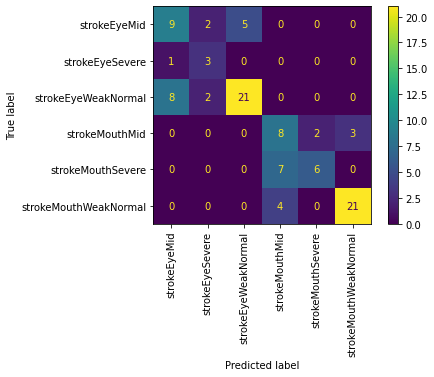

<Figure size 7200x7200 with 0 Axes>

In [ ]:
# Implement confusion matrix

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

# Join list of actual detections of both eye and mouth
A=None
A1 = eye_actual
A1.extend(mouth_actual)

# Join list of predicted detections of both eye and mouth
P=None
P1 = eye_detections
P1.extend(mouth_detections)

print(eye_actual)
print(eye_detections)


confusion_matrix = metrics.confusion_matrix(A1, P1, normalize=None)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["strokeEyeMid","strokeEyeSevere","strokeEyeWeakNormal","strokeMouthMid","strokeMouthSevere","strokeMouthWeakNormal"])

#Labels={1: "strokeEyeMid", 2: "strokeEyeSevere", 3: "strokeEyeWeakNormal", 4: "strokeMouthMid", 5: "strokeMouthSevere", 6: "strokeMouthWeakNormal"}

cm_display.plot()
plt.xticks(rotation=90)
plt.figure(figsize=(100, 100))
plt.show()

In [ ]:
print(len(P1))

102
